In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import random
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image, ImageChops, ImageEnhance
from IPython.display import display # to display images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_original = '/content/drive/My Drive/training/pristine/'
path_tampered = '/content/drive/My Drive/training/fake/'

total_orig = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)

In [4]:
total_tampered.remove('.DS_Store')

In [5]:
len(total_orig),len(total_tampered)

(1050, 451)

In [6]:
images = []
for file in tqdm(total_orig):  #choose all pristine
    try:
        if file.endswith('png'):
                line = path_original + file  + ',0\n'
                images.append(line)
    except:
        print(path_original+file)
        
for file in tqdm(total_tampered):       #choose all tampered images
    try:
        if file.endswith('png'):
                    line = path_tampered + file + ',1\n'
                    images.append(line)

    except:
          print(path_tampered+file)

100%|██████████| 451/451 [00:00<00:00, 485033.62it/s]


In [7]:
X_f = []
Y_f = []

In [8]:
len(images)


1500

In [9]:
image_name = []
label = []
for i in tqdm(range(len(images))):
    image_name.append(images[i][0:-3])
    label.append(images[i][-2])

100%|██████████| 1500/1500 [00:00<00:00, 589916.17it/s]


In [10]:
dataset = pd.DataFrame({'image':image_name,'class_label':label})

In [11]:
dataset.head(2)

,image,class_label
0,/content/drive/My Drive/training/pristine/6d11...,0
1,/content/drive/My Drive/training/pristine/3c96...,0


In [12]:
dataset.tail(2)

,image,class_label
1498,/content/drive/My Drive/training/fake/b35d925d...,1
1499,/content/drive/My Drive/training/fake/72918449...,1


In [13]:
dataset.shape

(1500, 2)

Text(0.5, 1.0, 'Images belomging to each class')

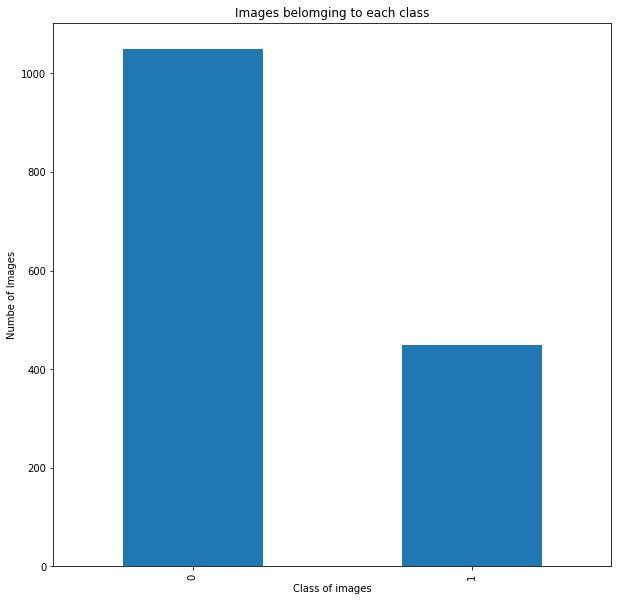

In [15]:
plt.figure(figsize = (10,10))
k = dataset['class_label'].value_counts()
k.plot(kind = 'bar')
plt.xlabel("Class of images")
plt.ylabel("Numbe of Images")
plt.title("Images belomging to each class")

In [16]:
dataset['image']

0       /content/drive/My Drive/training/pristine/6d11...
1       /content/drive/My Drive/training/pristine/3c96...
2       /content/drive/My Drive/training/pristine/0d6d...
3       /content/drive/My Drive/training/pristine/1b28...
4       /content/drive/My Drive/training/pristine/4bc6...
                              ...                        
1495    /content/drive/My Drive/training/fake/12362143...
1496    /content/drive/My Drive/training/fake/b9c5470e...
1497    /content/drive/My Drive/training/fake/be05023f...
1498    /content/drive/My Drive/training/fake/b35d925d...
1499    /content/drive/My Drive/training/fake/72918449...
Name: image, Length: 1500, dtype: object

In [17]:
def ELA(img_path):
    """Performs Error Level Analysis over a directory of images"""
    
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])

    return diff

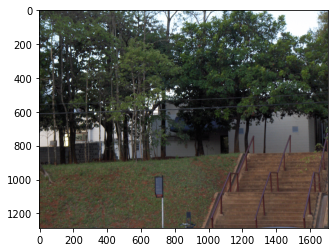

In [18]:
x=Image.open(dataset['image'][1350])
plt.imshow(x)

**LETS SEE THE MAGNIFIED ELA FOR THE ABOVE IMAGE**

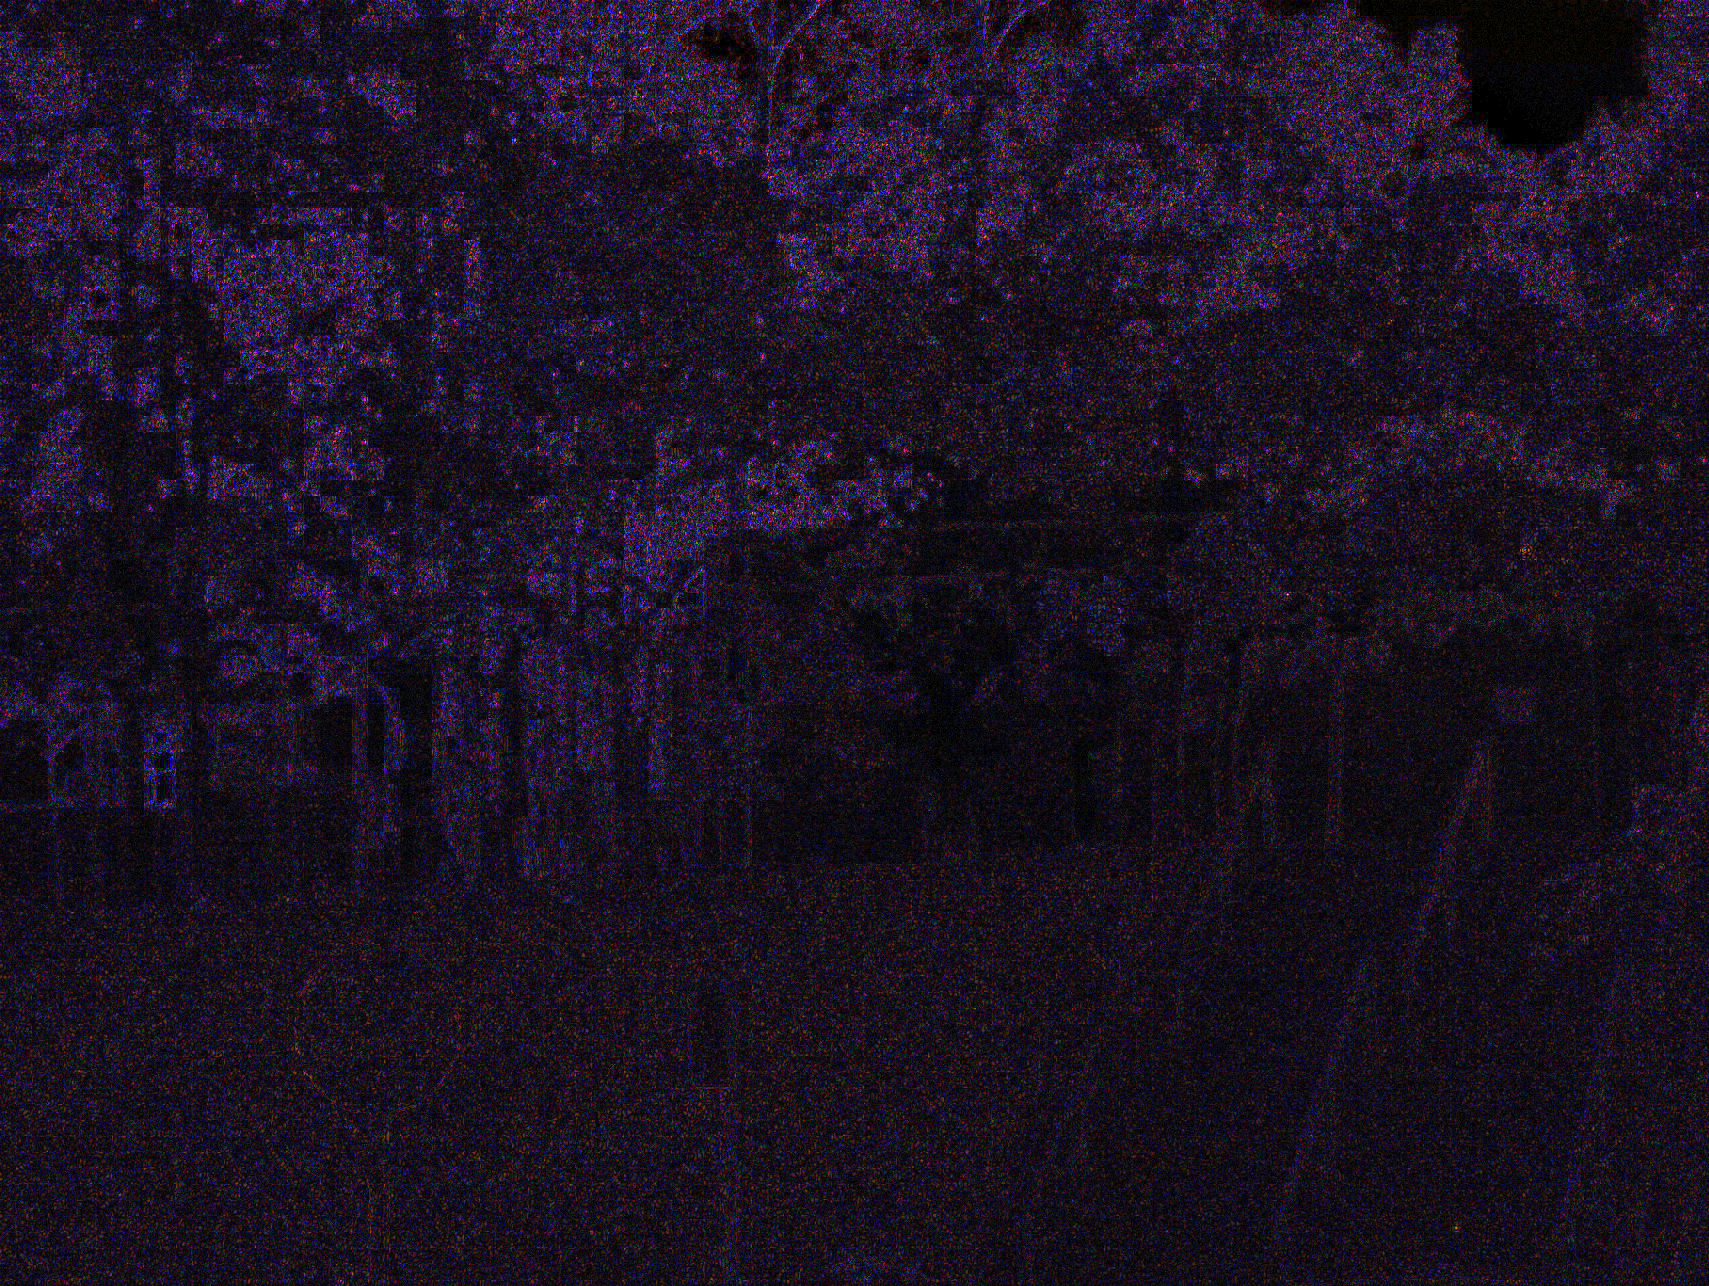

In [19]:
ELA(dataset['image'][1350])

In [20]:
for index, row in tqdm(dataset.iterrows()):
    X_f.append(np.array(ELA(row[0]).resize((128, 128))).flatten() / 255.0)
    Y_f.append(row[1])

1500it [48:26,  1.94s/it]


In [21]:
#converting X and Y to numpy arrays
x_casia = np.array(X_f)
y_casia = np.array(Y_f)

In [22]:
print(x_casia.shape)
print(y_casia.shape)

(1500, 49152)
(1500,)


In [23]:
x_casia = x_casia.reshape(-1, 128, 128, 3)
y_casia = to_categorical(y_casia, 2)     #y is one hot encoded

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(x_casia, y_casia, test_size = 0.2, random_state=5)

In [25]:
X_train.shape

(1200, 128, 128, 3)

In [26]:
Y_train.shape

(1200, 2)

In [27]:
X_val.shape

(300, 128, 128, 3)

In [28]:
Y_val.shape

(300, 2)

In [29]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [30]:
optimizer = Adam()

In [31]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [33]:
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

In [34]:
X_train.shape

(1200, 128, 128, 3)

In [35]:
history = model.fit(X_train, Y_train, batch_size = 100, epochs = 5, 
          validation_data = (X_val, Y_val), verbose = 1, callbacks=[early_stopping])

Epoch 1/5
12/12 [==============================] - 101s 8s/step - loss: 1.2505 - accuracy: 0.6725 - val_loss: 0.3935 - val_accuracy: 0.7200
Epoch 2/5
12/12 [==============================] - 102s 8s/step - loss: 0.2752 - accuracy: 0.8767 - val_loss: 0.1936 - val_accuracy: 0.9400
Epoch 3/5
12/12 [==============================] - 101s 8s/step - loss: 0.1813 - accuracy: 0.9375 - val_loss: 0.1772 - val_accuracy: 0.9500
Epoch 4/5
12/12 [==============================] - 102s 8s/step - loss: 0.1695 - accuracy: 0.9375 - val_loss: 0.1753 - val_accuracy: 0.9433
Epoch 5/5
12/12 [==============================] - 102s 8s/step - loss: 0.1628 - accuracy: 0.9425 - val_loss: 0.1671 - val_accuracy: 0.9500


In [36]:
model.save('new_model_casia.h5')

In [37]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
y_pred_cnn = model.predict(x_casia)
y_pred_cnn = np.argmax(y_pred_cnn,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_casia,axis = 1) 

score = metrics.precision_score(Y_true,y_pred_cnn, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, y_pred_cnn, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true, y_pred_cnn, average= "weighted")
print("F1 score: {}".format(score_lr1))

Precision score: 0.9493004663557628
Recall score: 0.948
F1 score: 0.9483747466406426
